In [3]:
import os
from keras.utils import get_file
import gensim
import subprocess
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize
figsize(10,10)
from sklearn import svm
from sklearn.manifold import TSNE
import json
from collections import Counter
from itertools import chain
import random
import requests
import geopandas as gpd
import csv

In [4]:
MODEL='GoogleNews-vectors-negative300.bin'
path=get_file(MODEL + '.gz', 'https://s3.amazonaws.com/dl4j-distribution/%s.gz' % MODEL)
if not os.path.isdir('generated'):
    os.mkdir('generated')
unzipped=os.path.join('generated', MODEL)
if not os.path.isfile(unzipped):
    with open(unzipped, 'wb') as fout:
        zcat = subprocess.Popen(['zcat'], stdin=open(path), stdout=fout)
        zcat.wait()

In [5]:
model=gensim.models.KeyedVectors.load_word2vec_format(unzipped, binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [8]:
model.most_similar(positive=['espresso'])

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('cappuccino', 0.6888186931610107),
 ('mocha', 0.6686208248138428),
 ('coffee', 0.6616826057434082),
 ('latte', 0.6536753177642822),
 ('caramel_macchiato', 0.6491267681121826),
 ('ristretto', 0.6485546827316284),
 ('espressos', 0.6438628435134888),
 ('macchiato', 0.6428250074386597),
 ('chai_latte', 0.6308027505874634),
 ('espresso_cappuccino', 0.6280542612075806)]

In [9]:
def A_is_to_B_as_C_is_to(a,b,c,topn=1):
  a,b,c=map(lambda x: x if type(x)==list else [x],(a,b,c))
  res=model.most_similar(positive=b+c, negative=a, topn=topn)
  if len(res):
    if topn==1:
      return res[0][0]
    return [x[0] for x in res]
  return None

In [11]:
A_is_to_B_as_C_is_to('king','queen','man')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


'woman'

In [12]:
for country in 'Italy','France','India','China':
  print('%s is the capital of %s'% (A_is_to_B_as_C_is_to('Germany','Berlin',country),country))

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


Rome is the capital of Italy
Paris is the capital of France
Delhi is the capital of India
Beijing is the capital of China


In [14]:
for company in 'Google', 'IBM', 'Boeing', 'Microsoft', 'Samsung':
  products = A_is_to_B_as_C_is_to(['Starbucks', 'Apple'], ['Starbucks_coffee', 'iPhone'], company, topn=3)
  print('%s -> %s' % (company, ', '.join(products)))

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


Google -> personalized_homepage, app, Gmail
IBM -> DB2, WebSphere_Portal, Tamino_XML_Server
Boeing -> Dreamliner, airframe, aircraft
Microsoft -> Windows_Mobile, SyncMate, Windows
Samsung -> MM_A###, handset, Samsung_SCH_B###


In [19]:
beverages = ['espresso', 'beer', 'vodka', 'wine', 'cola', 'tea']
countries = ['Italy', 'Germany', 'Russia', 'France', 'USA', 'India']
sports = ['soccer', 'handball', 'hockey', 'cycling', 'basketball', 'cricket']
items = beverages + countries + sports

item_vectors=[(item,model[item]) for item in items if item in model]

In [20]:
#t-distributed stochastic neighbour embedding

vectors=np.asarray([x[1] for x in item_vectors])
lengths=np.linalg.norm(vectors, axis=1)
norm_vectors=(vectors.T/lengths).T
tsne=TSNE(n_components=2, perplexity=10, verbose=2).fit_transform(norm_vectors)

[t-SNE] Computing 17 nearest neighbors...
[t-SNE] Indexed 18 samples in 0.000s...
[t-SNE] Computed neighbors for 18 samples in 0.018s...
[t-SNE] Computed conditional probabilities for sample 18 / 18
[t-SNE] Mean sigma: 0.581543
[t-SNE] Computed conditional probabilities in 0.018s
[t-SNE] Iteration 50: error = 75.1306458, gradient norm = 0.8357976 (50 iterations in 0.027s)
[t-SNE] Iteration 100: error = 60.5361786, gradient norm = 0.2923334 (50 iterations in 0.010s)
[t-SNE] Iteration 150: error = 62.1770287, gradient norm = 0.1628571 (50 iterations in 0.009s)
[t-SNE] Iteration 200: error = 65.2976990, gradient norm = 0.0659866 (50 iterations in 0.009s)
[t-SNE] Iteration 250: error = 58.2293167, gradient norm = 0.0606765 (50 iterations in 0.008s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.229317
[t-SNE] Iteration 300: error = 0.9287155, gradient norm = 0.0009684 (50 iterations in 0.008s)
[t-SNE] Iteration 350: error = 0.7483113, gradient norm = 0.0006175 (50 i

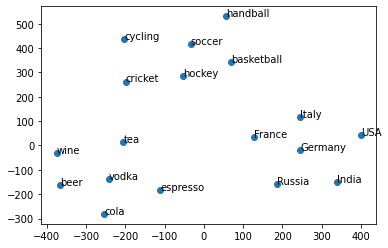

In [21]:
x=tsne[:,0]
y=tsne[:,1]

fig,ax=plt.subplots()
ax.scatter(x,y)

for item,x1,y1 in zip(item_vectors,x,y):
  ax.annotate(item[0],(x1,y1))

plt.show()

In [32]:
import pandas as pd
c=pd.read_csv('https://raw.githubusercontent.com/DOsinga/deep_learning_cookbook/master/data/countries.csv')
c.to_csv('/content/drive/My Drive/Colab Notebooks/Word Embedings and Text SImilarity/countries.csv')

In [7]:
countries=list(csv.DictReader(open('/content/drive/My Drive/Colab Notebooks/Word Embedings and Text SImilarity/countries.csv')))
countries[:10]

[OrderedDict([('', '0'), ('name', 'Canada'), ('cc', 'ca'), ('cc3', 'can')]),
 OrderedDict([('', '1'),
              ('name', 'Turkmenistan'),
              ('cc', 'tm'),
              ('cc3', 'tkm')]),
 OrderedDict([('', '2'), ('name', 'Ethiopia'), ('cc', 'et'), ('cc3', 'eth')]),
 OrderedDict([('', '3'), ('name', 'Swaziland'), ('cc', 'sz'), ('cc3', 'swz')]),
 OrderedDict([('', '4'),
              ('name', 'Czech_Republic'),
              ('cc', 'cz'),
              ('cc3', 'cze')]),
 OrderedDict([('', '5'), ('name', 'Cameroon'), ('cc', 'cm'), ('cc3', 'cmr')]),
 OrderedDict([('', '6'), ('name', 'UAE'), ('cc', 'ae'), ('cc3', 'are')]),
 OrderedDict([('', '7'), ('name', 'Liberia'), ('cc', 'lr'), ('cc3', 'lbr')]),
 OrderedDict([('', '8'),
              ('name', 'Netherlands'),
              ('cc', 'nl'),
              ('cc3', 'nld')]),
 OrderedDict([('', '9'),
              ('name', 'East_Timor'),
              ('cc', 'tl'),
              ('cc3', 'tls')])]

In [8]:
positive=[x['name'] for x in random.sample(countries,40)]
negative=random.sample(model.vocab.keys(),5000)

In [9]:
labelled = [(p, 1) for p in positive] + [(n, 0) for n in negative]
random.shuffle(labelled)
X = np.asarray([model[w] for w, l in labelled])
y = np.asarray([l for w, l in labelled])

In [10]:
TRAINING_FRACTION = 0.3
cut_off = int(TRAINING_FRACTION * len(labelled))
clf = svm.SVC(kernel='linear')
clf.fit(X[:cut_off], y[:cut_off])

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [11]:
res = clf.predict(X[cut_off:])

missed = [country for (pred, truth, country) in 
 zip(res, y[cut_off:], labelled[cut_off:]) if pred != truth]

100 - 100 * float(len(missed)) / len(res), missed

(99.94331065759637, [('North_Korea', 1), ('Qatari', 0)])

In [12]:
all_predictions=clf.predict(model.syn0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  """Entry point for launching an IPython kernel.


In [14]:
res = []
for word, pred in zip(model.index2word, all_predictions):
    if pred:
        res.append(word)
        if len(res) == 150:
            break
random.sample(res, 10)

['Romania',
 'SA',
 'countries',
 'Gaza_Strip',
 'Thailand',
 'UK',
 'Cyprus',
 'Ecuador',
 'New_Zealand',
 'Kosovo']

In [15]:
country_to_idx = {country['name']: idx for idx, country in enumerate(countries)}
country_vecs = np.asarray([model[c['name']] for c in countries])
country_vecs.shape

(184, 300)

In [16]:
dists = np.dot(country_vecs, country_vecs[country_to_idx['Canada']])
for idx in reversed(np.argsort(dists)[-10:]):
    print(countries[idx]['name'], dists[idx])

Canada 7.544024
New_Zealand 3.9619699
Finland 3.9392407
Puerto_Rico 3.838145
Jamaica 3.8102932
Sweden 3.8042789
Slovakia 3.703874
Australia 3.671101
Bahamas 3.6240416
United_States 3.5374339


In [17]:
def rank_countries(term, topn=10, field='name'):
    if not term in model:
        return []
    vec = model[term]
    dists = np.dot(country_vecs, vec)
    return [(countries[idx][field], float(dists[idx])) 
            for idx in reversed(np.argsort(dists)[-topn:])]

In [20]:
rank_countries('cricket')

[('Sri_Lanka', 5.92276668548584),
 ('Zimbabwe', 5.336524963378906),
 ('Bangladesh', 5.192489147186279),
 ('Pakistan', 4.948408126831055),
 ('Guyana', 3.9162838459014893),
 ('Barbados', 3.757995128631592),
 ('India', 3.7504398822784424),
 ('South_Africa', 3.6561501026153564),
 ('New_Zealand', 3.642028570175171),
 ('Fiji', 3.608567714691162)]

In [21]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [22]:
def map_term(term):
    d = {k.upper(): v for k, v in rank_countries(term, topn=0, field='cc3')}
    world[term] = world['iso_a3'].map(d)
    world[term] /= world[term].max()
    world.dropna().plot(term, cmap='OrRd')

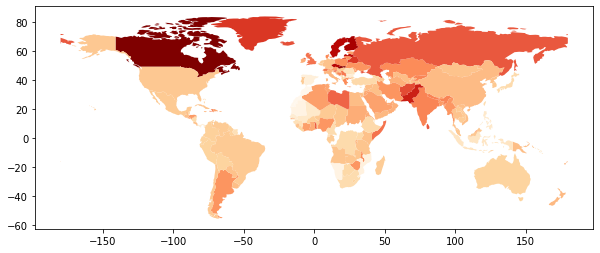

In [24]:
map_term('hockey')